# Project Introduction

Every time we do an analysis, we need to formulate several testing and test analyzes that we need to test further. Sometimes, the tests we do lead us to accept the hypothesis, other times we also need to reject it. To make the right decisions in business, we must understand whether the assumptions we make are correct or not.

In this project as an analyst I have received an analytical assignment from an international online store. My predecessor failed to complete this task: He briefly ran A/B testing before finally quitting his job and leaving only the technical specifications and the results of the experiments he did.

## Purpose:
1. How many users in each group?    
2. What's the distribution of users across date?
3. What events are in the log and how often do they occur?
4. See if there is a statistically significant difference between groups for all events


## Steps
As for the data that we will retrieve and analyze stored in several files:
- `/datasets/ab_project_marketing_events_us.csv`
- `/datasets/final_ab_new_users_upd_us.csv`
- `/datasets/final_ab_events_upd_us.csv`
- `/datasets/final_ab_participants_upd_us.csv`


There are several steps of the analysis this time, namely:
1. Download data and prepare it for analysis
2. Data exploration
3. Explorative data analysis (EDA)
4. A/B testing
6. Conclusion


# Step 1. Download data and prepare it for analysis

## Create library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mth
import seaborn as sns
import plotly
import scipy.stats as stats
import plotly.express as px
from plotly import graph_objs as go
from __future__ import division
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline

from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 15)
pd.set_option('display.max_columns', 300)

## Load the data

In the following Data Overview, we'll open up the data using `head()`, `info()`, `describe()`, and `isnull().sum()` functions to further explore the dataset.

- **Marketing event calendar for 2020**
    
    This `Project Marketing` table contains the following columns:
    - name — the name of the marketing event
    - regions — the regions where the advertisement campaign will take place
    - start_dt — campaign start date
    - finish_dt — campaign end date

In [2]:
marketing = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
marketing.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [3]:
# getting dataset infromation
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
# getting statical information about our dataset
marketing.describe()

,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,4th of July Promo,APAC,2020-05-01,2020-07-11
freq,1,4,1,1


In [5]:
# check for missing value
marketing.isnull().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

It can be seen from the result that marketing dataset seems great, there is no missing value detected and all the features are complete. However, there is something we need to be fixed which is the data type for columns `start_dt` and `finish_dt` before continuing to the next step (Exploratory Data Analysis).

- **All users who registered in the online shop from December 7 to 21, 2020**

    This `Users` table contains the following columns:
    - user_id
    - first_date — date of registration (sign up)
    - region — the region where the user registered
    - device — the device used to register

In [6]:
users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [7]:
# getting dataset information
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [8]:
# getting statical information about our dataset
users.describe()

,user_id,first_date,region,device
count,58703,58703,58703,58703
unique,58703,17,4,4
top,05B6E16B5E29D902,2020-12-21,EU,Android
freq,1,6077,43396,26159


In [9]:
users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [10]:
# check for missing value
users.isnull().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [11]:
# checking dublicate rows in dataset
users.duplicated().sum()

0

Users dataset seems to be fine without finding missing value or duplicate and all the features are oke, even though we still need to fix data type in column `first_date` (datetime).

- **All events from new users throughout the period 7 December 2020 to 1 January 2021**

    This `Events` table contains the following columns:
    - user_id
    - event_dt — event date and time
    - event_name — the name of the event type
    - details — additional data related to the event (for example, the total order amount in USD for the purchase event)

In [12]:
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.989999999999995
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.990000000000000
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.990000000000000
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.990000000000000
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.990000000000000


In [13]:
# getting dataset information
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [14]:
# getting statical information about our dataset
events.describe()

,details
count,60314.000000000000000
mean,23.881219285737977
std,72.228883954038281
min,4.990000000000000
25%,4.990000000000000
50%,4.990000000000000
75%,9.990000000000000
max,499.990000000000009


In [15]:
print(events['event_name'].unique())
events['details'].describe()

['purchase' 'product_cart' 'product_page' 'login']


count    60314.000000000000000
mean        23.881219285737977
std         72.228883954038281
min          4.990000000000000
25%          4.990000000000000
50%          4.990000000000000
75%          9.990000000000000
max        499.990000000000009
Name: details, dtype: float64

In [16]:
# check for missing value
events.isnull().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

In [17]:
# checking dublicate rows in dataset
events.duplicated().sum()

0

The result shows that there is missing value in the `details` column as many as 363447 entries and we also need to fix the data type for `event_dt`(datetime), before continuing to EDA.

- **List of experimental participants**

    This `Participants` table contains the following columns:
    - user_id
    - ab_test — experiment name
    - group — the experimental group the user is from

In [18]:
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [19]:
# getting dataset infromation
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [20]:
# check for missing value
participants.isnull().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [21]:
# check for dublicate rows in dataset
participants.duplicated().sum()

0

In [22]:
participants['group'].unique()

array(['A', 'B'], dtype=object)

In [23]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

The dataset participants looked safe, there were no cases of missing values or incorrect data types found. All features complete and perfect.

## Data exploration (Convert Data Type)

- **Convert Data Type**

In [24]:
# Marketing
marketing.dtypes

name         object
regions      object
start_dt     object
finish_dt    object
dtype: object

In [25]:
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing.dtypes

name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object

In [26]:
# Users
users.dtypes

user_id       object
first_date    object
region        object
device        object
dtype: object

In [27]:
users['first_date'] = pd.to_datetime(users['first_date'])
#switching to more efficient datatypes
users['region'] = users['region'].astype('category')
users['device'] = users['device'].astype('category')
users.dtypes

user_id               object
first_date    datetime64[ns]
region              category
device              category
dtype: object

In [28]:
# Events
events.dtypes

user_id        object
event_dt       object
event_name     object
details       float64
dtype: object

In [29]:
#switching to more efficient datatypes
events['event_name'] = events['event_name'].astype('category')
events['details'] = events['details'].astype('float16')
events['details'] = events['details'].apply(lambda x: round(x, 2))
events['event_dt'] = pd.to_datetime(events['event_dt'])
events.dtypes

user_id               object
event_dt      datetime64[ns]
event_name          category
details              float64
dtype: object

In [30]:
# Participants
participants.dtypes

user_id    object
group      object
ab_test    object
dtype: object

In [31]:
#switching to more efficient datatypes
participants['group'] = participants['group'].astype('category')
participants['ab_test'] = participants['ab_test'].astype('category')
participants.dtypes

user_id      object
group      category
ab_test    category
dtype: object

All data types are fixed some of data type were changed to be category to make it easier in the next step to be processed.

## Data exploration (Missing Value)

- **Handling missing value**

    At this stage, before we make a decision to deal with missing values, we will first find out the cause of the missing values. Let's look at the stages as follows:

In [32]:
# count NaN 
events['details'].isnull().sum()

363447

In [33]:
events.tail(10)

,user_id,event_dt,event_name,details
423751,1455450835F72F5E,2020-12-30 09:27:10,login,NaN
423752,339C4C55021A83C6,2020-12-30 12:55:08,login,NaN
423753,33E7BCF696B41C7B,2020-12-30 12:21:24,login,NaN
423754,D1553B56FFA8974B,2020-12-30 03:15:35,login,NaN
423755,6181F3835EBE66BF,2020-12-30 12:00:00,login,NaN
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN
423760,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN


In [34]:
events.event_name.unique()

['purchase', 'product_cart', 'product_page', 'login']
Categories (4, object): ['purchase', 'product_cart', 'product_page', 'login']

From the results displayed, it can be concluded that the missing values in the `details` column are caused by the activities of users who only log in without completing the purchase stages, so the system does not read and cannot calculate the process until the end of the purchase. Thus, what we need to do next is, fill in the missing values with `df.fillna(0)` because there is no purchase process.

In [35]:
events['details'] = events['details'].fillna(0)
events.tail()

,user_id,event_dt,event_name,details
423756,245E85F65C358E08,2020-12-30 19:35:55,login,0.0
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.0
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.0
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.0
423760,7AEC61159B672CC5,2020-12-30 11:36:13,login,0.0


In [36]:
events.isnull().sum()

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

The case of missing values has been resolved, and the data is safe for the EDA process.

## Data exploration (Duplicates)

- **Checking and handling duplicate value**

    At this stage, before we make a decision to deal with duplicate values, we will first find out the cause of the duplicate values. Let's look at the stages as follows:

In [37]:
#combining user data with test data to compare region and test groups
users = pd.merge(users, participants, how='left', on='user_id')

users['group'] = users['group'].cat.add_categories('none')
users['group'].fillna('none', inplace = True) 
users.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,none,NaN
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,none,NaN


In [38]:
users['ab_test'] = users['ab_test'].cat.add_categories('none')
users['ab_test'].fillna('none', inplace = True) 

users.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,none,none
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,none,none


In [39]:
all_users = users.pivot_table(values='user_id', index=['ab_test','group'], columns='region', aggfunc='count')
all_users

region                         APAC   CIS     EU  N.America
ab_test                 group                              
interface_eu_test       A         0     0   5467          0
                        B         0     0   5383          0
                        none      0     0      0          0
recommender_system_test A        28    19   2604         96
                        B        17    11    877         23
                        none      0     0      0          0
none                    A         0     0      0          0
                        B         0     0      0          0
                        none   3081  3100  29952       8932

In [40]:
#totals
all_users.sum(axis=0) 

region
APAC          3126
CIS           3130
EU           44283
N.America     9051
dtype: int64

In [41]:
#Finding 15% of the EU total
44283*.15

6642.45

Conclusion: there are two tests presented and their users are not equal to 6000. Interface_eu_test has 6000 (nearly) for groups A and B, and no users from other regions, so let's assume that is defined, but will handle testing separately from now on.

- Check for duplicate users

In [42]:
users.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,none,none
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,none,none


In [43]:
#eu_test
eu_test = users.query('ab_test == "interface_eu_test"')
eu_test.head()

,user_id,first_date,region,device,group,ab_test
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
13,5BE017E9C8CC42F8,2020-12-07,EU,Android,B,interface_eu_test
17,96F27A054B191457,2020-12-07,EU,iPhone,B,interface_eu_test
20,DD4352CDCF8C3D57,2020-12-07,EU,Android,A,interface_eu_test


In [44]:
eu_test[eu_test.duplicated(['user_id'], keep=False)].sort_values(by='user_id')

,user_id,first_date,region,device,group,ab_test


In [45]:
#recommender_system_test
recommender_test = users.query('ab_test == "recommender_system_test"')
recommender_test.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
19,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
23,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
39,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
40,29C92313A98B1176,2020-12-07,APAC,Android,B,recommender_system_test


In [46]:
recommender_test[recommender_test.duplicated(['user_id'], keep=False)].sort_values(by='user_id')

,user_id,first_date,region,device,group,ab_test


- Dropping duplicate users from eu and recommender tests

In [47]:
print(eu_test['user_id'].nunique())
recommender_test['user_id'].nunique()

10850


3675

In [48]:
common_users = pd.merge(eu_test, recommender_test, how='inner', left_on='user_id', right_on='user_id')
common_users = common_users['user_id']
common_users

0      DD4352CDCF8C3D57
1      6A581C74EF4D5F44
2      2B06EB547B7AAD08
3      DF40EF85F55A958D
4      CBEFCA3BFDE4CC58
             ...       
882    32E13C1C0F6AC96E
883    549A5092FD1BD5D9
884    C27F677720E68EA4
885    902F92052587344F
886    A09DFE27D4CFF8E8
Name: user_id, Length: 887, dtype: object

In [49]:
eu_test = eu_test.query('user_id not in @common_users')
eu_test.count()

user_id       9963
first_date    9963
region        9963
device        9963
group         9963
ab_test       9963
dtype: int64

In [50]:
recommender_test = recommender_test.query('user_id not in @common_users')
recommender_test.count()

user_id       2788
first_date    2788
region        2788
device        2788
group         2788
ab_test       2788
dtype: int64

- Dropping duplicate users from user_events

In [51]:
events.count()

user_id       423761
event_dt      423761
event_name    423761
details       423761
dtype: int64

In [52]:
events.query('user_id not in @common_users').count()

user_id       418046
event_dt      418046
event_name    418046
details       418046
dtype: int64

In [53]:
events = pd.merge(events, participants[['user_id','ab_test']], on='user_id', how='left')

events['ab_test'] = events['ab_test'].cat.add_categories('none')
events['ab_test'].fillna('none', inplace = True) 

events.head()

,user_id,event_dt,event_name,details,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,100.00,none
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,none
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,none
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,interface_eu_test
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,none


In [54]:
events.groupby(['user_id'])['ab_test'].nunique().reset_index().query('ab_test > 1')

,user_id,ab_test
14,001064FEAAB631A1,2
50,00341D8401F0F665,2
117,0082295A41A867B5,2
201,00E68F103C66C1F7,2
207,00EFA157F7B6E1C4,2
...,...,...
58395,FEA0C585A53E7027,2
58426,FEC0BCA6C323872F,2
58514,FF2174A1AA0EAD20,2
58543,FF44696E39039D29,2


In [55]:
events = events.query('user_id not in @common_users')
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418046 entries, 0 to 429475
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     418046 non-null  object        
 1   event_dt    418046 non-null  datetime64[ns]
 2   event_name  418046 non-null  category      
 3   details     418046 non-null  float64       
 4   ab_test     418046 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(1), object(1)
memory usage: 13.6+ MB


All duplicate data in the user has been resolved and safe. Next, let's go to the EDA stage.

# Step 2. Explorative Data Analysis A/B Testing

Technical description
Test name: recommender_system_test
Groups: А (control), B (new payment funnel)

Launch date: 07-12-2020
The date they stopped accepting new users: 2020-12-21
End date: 01-01-2021

Audience: 15% of new users from the EU region
Test objective: test changes related to the introduction of an improved recommendation system
Expected result: within 14 days after signing up, users will show better conversions to product page views (product_page events), product card views (product_card), and purchases (purchases). At each stage of product_page → product_card → purchase, there will be at least a 10% increase.
Expected number of test takers: 6000

## Study conversions at different stages of the funnel

In [56]:
events['date'] = events['event_dt'].dt.date
events['date'] = pd.to_datetime(events['date'])
events

,user_id,event_dt,event_name,details,ab_test,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,100.00,none,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,none,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,none,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,interface_eu_test,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,none,2020-12-07
...,...,...,...,...,...,...
429471,245E85F65C358E08,2020-12-30 19:35:55,login,0.00,none,2020-12-30
429472,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.00,none,2020-12-30
429473,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.00,none,2020-12-30
429474,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.00,interface_eu_test,2020-12-30


In [57]:
# event counts
data_funnel = events['event_name'].value_counts().reset_index()
data_funnel.columns = ['event_name', 'event_count']
data_funnel

,event_name,event_count
0,login,179861
1,product_page,119274
2,purchase,59494
3,product_cart,59417


In [58]:
#dictionary for mapping
event_mapping = {
    'login': 1,
    'product_page': 2,
    'product_cart': 3,
    'purchase': 4
}

# adding a new column with .map
data_funnel['event_code'] = data_funnel['event_name'].map(event_mapping)
data_funnel

,event_name,event_count,event_code
0,login,179861,1
1,product_page,119274,2
2,purchase,59494,4
3,product_cart,59417,3


In [59]:
data_funnel.sort_values('event_count', inplace=True,ascending=False)
data_funnel.reset_index(drop=True,inplace=True)
data_funnel['percent']=data_funnel['event_count']/(data_funnel['event_count'][0].sum())*100
data_funnel

,event_name,event_count,event_code,percent
0,login,179861,1,100.000000000000000
1,product_page,119274,2,66.314542897014917
2,purchase,59494,4,33.077765607886093
3,product_cart,59417,3,33.034954770628424


In [60]:
data_funnel = data_funnel.sort_values('event_code')
data_funnel

,event_name,event_count,event_code,percent
0,login,179861,1,100.000000000000000
3,product_cart,59417,3,33.034954770628424
1,product_page,119274,2,66.314542897014917
2,purchase,59494,4,33.077765607886093


In [61]:
#plotly to visualise funnel
fig = go.Figure(go.Funnel(
    y = data_funnel["event_name"],
    x = data_funnel["event_count"],
    customdata=data_funnel["percent"],
    texttemplate= "<b>%{label}: </B>%{value:.2s}"+"<br><b>% of Total:</b> %{customdata:.2f}%",
    textposition='inside',
    marker = {"color": ["lightyellow", "lightsalmon", "tan"]}
    ))
fig.update_yaxes(visible=False)
fig.update_layout(template='simple_white',     
                  title={'xanchor': 'center',
                         'yanchor': 'top',        
                         'y':0.9,
                         'x':0.5,
                         'text':"Customer Funnel for Purchase Journey"})
fig.show()

It can be seen from the Customer Funnel for Purchase Journey that:
1. The initial total of users entering the login is 182465 (100%)
2. users to product_page are 120862 (66%)
3. up to 60120 users in product_cart (32%)
4. users who succeeded in the final purchase stage were 60314 (33%)

Why is the purchase percentage result greater than the product_cart percentage? it is possible or caused, users from `product_page` directly make purchase transactions without saving them first in `product_cart`. Which is the result of the `purchase` obtained from the results of the `product_page` stage.

## The number of events per user is evenly distributed across the sample

- How many users in each group

In [62]:
events

,user_id,event_dt,event_name,details,ab_test,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,100.00,none,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,none,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,none,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,interface_eu_test,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,none,2020-12-07
...,...,...,...,...,...,...
429471,245E85F65C358E08,2020-12-30 19:35:55,login,0.00,none,2020-12-30
429472,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.00,none,2020-12-30
429473,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.00,none,2020-12-30
429474,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.00,interface_eu_test,2020-12-30


In [63]:
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


In [64]:
#Merging group data into event data
events = pd.merge(events, participants[['user_id','group']], on='user_id', how='left')
events

,user_id,event_dt,event_name,details,ab_test,date,group
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,100.00,none,2020-12-07,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,none,2020-12-07,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,none,2020-12-07,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,interface_eu_test,2020-12-07,B
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,none,2020-12-07,NaN
...,...,...,...,...,...,...,...
418041,245E85F65C358E08,2020-12-30 19:35:55,login,0.00,none,2020-12-30,NaN
418042,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.00,none,2020-12-30,NaN
418043,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.00,none,2020-12-30,NaN
418044,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.00,interface_eu_test,2020-12-30,A


In [65]:
#Adding a category and filling missing values for users not in a test group
events['group'] = events['group'].cat.add_categories('none')
events['group'].fillna('none', inplace = True) 
events.head()

,user_id,event_dt,event_name,details,ab_test,date,group
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,100.00,none,2020-12-07,none
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,none,2020-12-07,none
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,none,2020-12-07,none
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,interface_eu_test,2020-12-07,B
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,none,2020-12-07,none


In [66]:
events.pivot_table(index=['ab_test', 'group'], values='user_id', aggfunc='count')

user_id
ab_test                 group         
interface_eu_test       A        37135
                        B        36079
                        none         0
recommender_system_test A        14215
                        B         3979
                        none         0
none                    A            0
                        B            0
                        none    326638

From the results obtained, it can be seen that:
1. 37135 users are in interface_eu_test A
2. as many as 36079 users are in interface_eu_test B.
3. 14215 users are in recommender_system_test A
4. 3979 users are in recommender_system_test B
5. 326638 are not in either ab_test or group, because their process only reaches login.

In [67]:
events.pivot_table(index='event_name', 
                        values='user_id', 
                        columns='ab_test',
                        aggfunc=pd.Series.nunique).sort_values(by='none', ascending=False)


ab_test,interface_eu_test,recommender_system_test,none
event_name,,,
login,9962,2787,45060
product_page,6620,1757,30006
purchase,3435,850,15005
product_cart,3315,826,14890


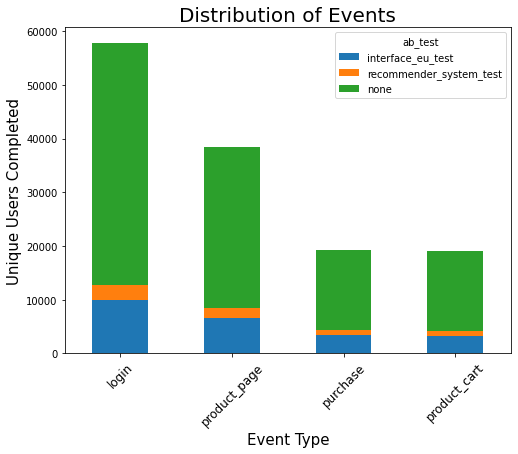

In [68]:
events.pivot_table(index='event_name', 
                        values='user_id', 
                        columns='ab_test',
                        aggfunc=pd.Series.nunique).sort_values(by='none', ascending=False).plot.bar(figsize=(8, 6), stacked=True, legend=True)

plt.title('Distribution of Events', fontsize=20)
plt.xlabel('Event Type', fontsize=15)
plt.ylabel('Unique Users Completed', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.show()

## Distribution of the number of events by day

In [69]:
#combining the test column and group column into one
events['ab_test'] = events['ab_test'].str.cat(events['group'],sep="_")
events.drop('group', axis=1, inplace=True)
events['ab_test'] = events['ab_test'].replace('none_none', 'none')
events.head()

,user_id,event_dt,event_name,details,ab_test,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,100.00,none,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,none,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,none,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,interface_eu_test_B,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,none,2020-12-07


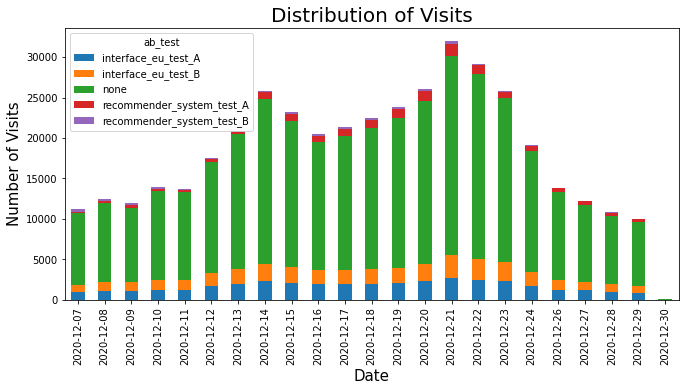

In [70]:
events['date'] = pd.DatetimeIndex(events['event_dt']).date

events.pivot_table(values='user_id', 
                 index='date', 
                 columns='ab_test', 
                 aggfunc='count').plot.bar(figsize=(11, 5), 
                                           stacked=True, 
                                           legend=True)

plt.title('Distribution of Visits', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of Visits', fontsize=15)
plt.show()

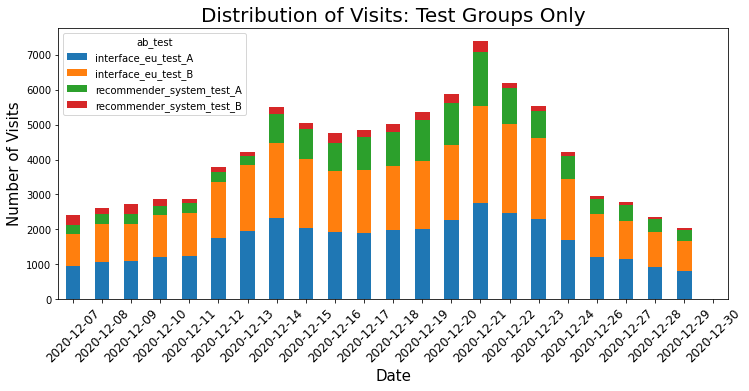

In [71]:
test_events = events.query('ab_test != "none"')

test_events.pivot_table(values='user_id', 
                 index='date', 
                 columns='ab_test', 
                 aggfunc='count').plot.bar(figsize=(12, 5), 
                                           stacked=True, 
                                           legend=True)

plt.title('Distribution of Visits: Test Groups Only', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of Visits', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.show()


Regardless of group there was a similar pattern, less visitat the beginning and end of the time periods with the biggest surges on and around Dec. 12 and Dec. 19th. These do not correspond to any particular promotion in the other df, but they were both Saturdays.

## Special features to consider before starting A/B testing

The following are special features that need to be prepared before conducting A/B testing:

- Set specific goals and hypotheses
- Ensure sufficient sample size for significant results.
- Do randomization in the selection of participants or users.
- Identify and control for other variables that may affect the results.
- Adequate duration planning.
- Prepare suitable statistical analysis methods.
- Carry out the test in accordance with ethical and safety rules.
- Document and report the results of A/B testing clearly.


By paying attention to these special features before conducting A/B testing, you can ensure that your tests are well-founded and produce results that are reliable and useful.

# Step 3. Evaluation of A/B testing results

## A/B testing results

The events in the log are Login, Product Page, Product Cart and then Purchase. Regardless of the group, about a third of users made it to the Purchase page except for group B recommender_system_test which had less than a third. The big anomaly seems to be that across groups there are often more visits to the Purchases page than the Cart page, which means users feel compelled to make a quick on-the-spot purchase.

## z test or z-test to test for statistical differences between the proportions

### See if there is a statistically significant difference between the groups¶

Select the most popular event in each control group, find the number of users who performed this action, their share, and check whether the difference between the groups is statistically significant

1. **recommender_test**

In [72]:
recommender = events.query('ab_test in ("recommender_system_test_A", "recommender_system_test_B")')
recommender_pivot = recommender.pivot_table(index='event_name', 
                 values='user_id', 
                 aggfunc=pd.Series.nunique).reset_index()

recommender_pivot.columns = ['event', 'users_completed']
recommender_pivot['proportion_of_total'] =  recommender_pivot['users_completed'] / recommender['user_id'].nunique()
recommender_pivot.sort_values(by='users_completed', ascending=False, inplace=True)
recommender_pivot

,event,users_completed,proportion_of_total
0,login,2787,0.999641319942611
2,product_page,1757,0.630200860832138
3,purchase,850,0.304878048780488
1,product_cart,826,0.296269727403156


In [73]:
recommender_funnel = recommender.pivot_table(index='event_name', 
                            values='user_id', 
                            columns='ab_test', 
                            aggfunc=pd.Series.nunique).reset_index().sort_values(by='recommender_system_test_A', ascending=False)
recommender_funnel

ab_test,event_name,recommender_system_test_A,recommender_system_test_B
0,login,2082,705
2,product_page,1360,397
3,purchase,652,198
1,product_cart,631,195


- **H0 - Null Hypothesis - there is no statistical diference between group A & B for login**
- **H1 - Alternate hypothesis- there is a statistical difference between groups A & B for login Alpha - .05**

In [74]:
def check_hypothesis(data, data_original, groupA, groupB, event, alpha = 0.05):
    #let's start with successes, using 
    successes1 = data[data.event_name == event][groupA].iloc[0]
    successes2 = data[data.event_name == event][groupB].iloc[0]
    
    #for trials we can go back to original df or used a pre-aggregated data
    trials1 = data_original[data_original.ab_test == groupA]['user_id'].nunique()
    trials2 = data_original[data_original.ab_test == groupB]['user_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1
    
    #proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Reject H0 for",event, 'and groups',groupA,groupB)
        print()
        print()
    else:
        print("Fail to Reject H0 for", event,'and groups',groupA,groupB)
        print()
        print()
        

In [75]:
check_hypothesis(recommender_funnel, recommender, 'recommender_system_test_A', 'recommender_system_test_B', 'login', alpha=0.05)

p-value:  0.08587401754779211
Fail to Reject H0 for login and groups recommender_system_test_A recommender_system_test_B




- **H0 - Null Hypothesis - there is no statistical diference between group A & B for subsequent events**
- **H1 - Alternate hypothesis- there is a statistical difference between groups A & B for subsequent events Alpha - .05**

In [76]:
for i in recommender_funnel.event_name.unique():
    check_hypothesis(recommender_funnel, recommender, 'recommender_system_test_A', 'recommender_system_test_B', i, alpha=0.05)

p-value:  0.08587401754779211
Fail to Reject H0 for login and groups recommender_system_test_A recommender_system_test_B


p-value:  1.5371909704686715e-05
Reject H0 for product_page and groups recommender_system_test_A recommender_system_test_B


p-value:  0.10281767567786759
Fail to Reject H0 for purchase and groups recommender_system_test_A recommender_system_test_B


p-value:  0.1766337419130104
Fail to Reject H0 for product_cart and groups recommender_system_test_A recommender_system_test_B




From the results obtained, it can be concluded that:
- There is no statistical difference between the recommended_test group A and B in the login event because the p_value result is slightly greater than the alpha value, which means it fails to reject H0, where the distribution of users for the log in event can be said to be evenly distributed.

- There is a statistical difference between group A and B in the product_page event which shows that the p_value is much greater than the alpha value, which means we can reject H0.

- There is no statistical difference between group A and B in the purchase event as shown by the result that the p_value is slightly greater than the alpha value, which means it fails to reject H0.

- There is no statistical difference between group A and B in the product_cart event as shown by the result that the p_value is slightly greater than the alpha value, which means it also fails to reject H0.

The statistical test cannot reject the hypothesis, which is that there is no statistical difference between groups A & B for the recommendation_test EXCEPT for product_page.

# Step. 5 Conclusion

It's safe to say that user visits peaked on and around Saturday. The funnel does show that there is a strong flow of users at login into the product_page, then having a drop in product_cart or purchase - in which case it can be concluded that the user bypasses the product_cart option and goes straight to the purchase process after being on the product_page option.

For statistical tests, we cannot reject the hypothesis that there is a statistical difference between most events in groups A & B. This means that something did change, but we cannot see whether it was for the better or worse. Ultimately, both A tests didn't make much of a difference.

Presentasi: <https://drive.google.com/file/d/1IupZCVKw1wT4uFLFxeCXmrvHasgOPHOg/view?usp=drive_link>